In [17]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
sys.path.append('/Users/Michael_Saha/Repositories/blahb')
import os, gdal, scipy.ndimage, numba, blahb
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline
sys.path.append('/Users/Michael_Saha/Repositories/')
from fire_sim import *

In [18]:
# Break into classes:
#
#    Landscape -> Environmental variables and fire history
#    Town -> Container for agents to loop over
#    
#    Calibration -> Contains a Landscape and manages the training/evaluation of 
#        fire behaviour against historical fire data.
#
#    ABM -> Container for parameterized Landscape and Towns of peoples.
#        Town (and home) behaviours depend on the Landscape and Town behaviours.

In [19]:
A_params = (np.nan, np.nan), (3.00, 0.30), (3.50, 0.30)
R_params = (np.nan, np.nan), (2.00, 1.65), (1.60, 1.65)
A_distr = [parameterize(np.random.gamma,*p) for p in A_params]
R_distr = [parameterize(np.random.gamma,*p) for p in R_params]

fname = '/Users/Michael_Saha/DATA/FotF/classed/classed1.tif'
B = gdal.Open(fname).ReadAsArray()
B = scipy.misc.imresize(B, (np.array(B.shape)/10).astype(int) )

#     Bare  Grass Wood
L_distr = [
     [1.0,  0.0,  0.0],  # 0 - Water
     [0.1,  0.1,  0.8],  # 1 - Rando
     [0.6,  0.3,  0.1],  # 2 - Urban
     [0.2,  0.6,  0.2],  # 3 - General
     [0.7,  0.2,  0.1],  # 4 - Sandy? 
     [0.8,  0.1,  0.1],  # 5 - Urban
     [1.0,  0.0,  0.0],  # 6 - Shallow water
     [0.1,  0.1,  0.8],  # 7 - Rando
     [1.0,  0.0,  0.0]   # 8 - Out of area
    ]

landscape = Landscape(B, L_distr, A_distr, R_distr)

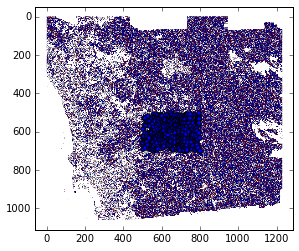

In [94]:
landscape.showL()
scatter(*homes)

In [4]:
class Agents:
    def __init__(self, pos, owns, initial_ds, risk, effect, policy, model):
        """Initialize a Town.
        
        Arguments:
            pos - 2-tuple of numpy.ndarray(size=N)
                Position of the homs on the landscape in integer coordinates
            
            initial_ds - numpy.ndarray(size=N, dtpye=float, range=[0,1])
                Initial defensible space realization.
            
            risk - numpy.ndarray(size=N, dtype=float)
                <>
            
            effect - numpy.ndarray(size=N, dtype=float)
                <>
            
            policy - numpy.ndarray(size=N, dtype=float)
                <>
            
            model - Callable that combines (risk, effect, policy, ...)
                and returns ds: float [0,1]
            
        Notes:
            risk is "realized_risk", which is risk * risk_beta and is static for each agent
            effect is "realized_effect" = effect * effect_beta
            policy is "realized_policy" = policy * policy_beta
        """
        self.pos = pos   # y, x
        self.ds = initial_ds
        self.risk = risk
        self.effect = effect
        self.policy = policy
        self.model = model
    
    
    @property
    def norms(self):
        return np.mean(self.ds)
    
    
    def update_ds(self):
        """Update each agents DS score using the statsmodel."""
        model(self.betas, self.risk_effect_pol, self.close_fires)
    
    
    def distance_to_nearest_fire(self, fires):
        """Find the agent distance to the nearest fires.
        
        Arguments:
            fires - list(blahb.PixelSet)
                Fires that have occured in the recent past
        """
        min_distances(fires[0])

In [88]:
@numba.jit(nopython=True)
def DS(l, ds_score):
    
    if l == 0:
        return 0
    
    r = np.random.rand()
    
    if l == 1: # Conversion probability of 
        if r < ds_score:
            return 0
        else:
            return 1
    
    elif l == 2: # DS conversion to 
        if r > ds_score:
            return 2
        elif r < ds_score/2:
            return 0
        else:
            return 1
    return 0

@numba.jit(nopython=True)
def ds_radius_function(L, y, x, ds_score, radius):
    """Apply defensible space to a landscape around a given pixel."""
    Y, X = L.shape
    for iy in range(y-radius, y+radius+1):
        if iy<0 or iy>=Y: continue
        for ix in range(x-radius,x+radius+1):
            # Bounds checking (or if this pixel has already been burned)
            if (ix < 0 or ix >= X):
                continue
            # If we're inside of max radius
            dist = euclidean_distance(y, x, iy, ix)
            if not dist <= radius:  # Apply the energy to the neighbor
                continue
            L[iy, ix] = DS(l, ds_score)


@numba.jit(nopython=True)
def apply_ds_to_radii(L, homes_y, homes_x, ds_scores, radii):
    """Apply the ds_radius_function to multiple homes."""
    for i in range(homes_y.size):
        ds_radius_function(L, homes_y[i], homes_x[i], ds_scores[i], radii[i])


@numba.jit(nopython=True)
def ds_pixelset_function(L, y_pix, x_pix, ds_score):
    """Apply defensible space to a set of pixels."""
    for iy, ix in zip(y_pix, x_pix):
        L[y_pix, x_pix] = DS(L[y_pix, x_pix], ds_score)


@numba.jit(nopython=True)
def apply_ds_to_pixelset(L, y_pixs, x_pixs, ds_scores):
    for y, x, d in zip(y_pixs, x_pixs, ds_scores):
        ds_pixelset_function(L, y, x, d)

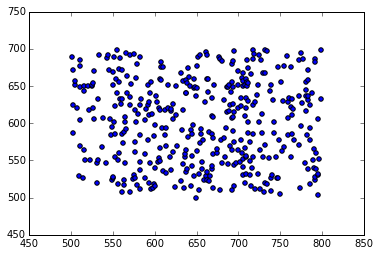

In [90]:
homes = blahb.PixelSet(np.random.randint(500,800,400), np.random.randint(500,700,400))
scatter(*homes)

In [91]:
class ABM:
    """Coupled Towns and Landscapes"""
    
    def __init__(agents, landscape):
        self.landscape = landscape
        self.agents = agents
    
    
    def apply_ds_to_L(self):
        """Update defensible space on the landscape using the thinning algorithm."""
        
    
    
    def update_ds(self):
        """Reset the agent neighborhoods to natural vegetation (from B).""" 
        
    
    def run_fire_season(self, n_pixels_to_burn):
        """Burn all of the fires in a season and update agents due to burns."""
        
    
    def update(self):
        self.update_ds()
        self.clear_ds()

In [92]:
A = np.arange(1000), np.arange(1000)
B = np.arange(100,200), np.arange(100,200)

distance = np.zeros(A[0].size)
%timeit d = min_distances(A, B, distance)
distance

1000 loops, best of 3: 945 µs per loop


array([  141.42135624,   140.00714267,   138.59292911,   137.17871555,
         135.76450199,   134.35028843,   132.93607486,   131.5218613 ,
         130.10764774,   128.69343418,   127.27922061,   125.86500705,
         124.45079349,   123.03657993,   121.62236636,   120.2081528 ,
         118.79393924,   117.37972568,   115.96551211,   114.55129855,
         113.13708499,   111.72287143,   110.30865787,   108.8944443 ,
         107.48023074,   106.06601718,   104.65180362,   103.23759005,
         101.82337649,   100.40916293,    98.99494937,    97.5807358 ,
          96.16652224,    94.75230868,    93.33809512,    91.92388155,
          90.50966799,    89.09545443,    87.68124087,    86.2670273 ,
          84.85281374,    83.43860018,    82.02438662,    80.61017306,
          79.19595949,    77.78174593,    76.36753237,    74.95331881,
          73.53910524,    72.12489168,    70.71067812,    69.29646456,
          67.88225099,    66.46803743,    65.05382387,    63.63961031,
      

In [93]:
# tuple of numpy arrays
# 